# AVISO Inversion with all data and swath data, no error

In [1]:
import numpy as np
import scipy
import gsw
import xarray as xr
import cmocean as cmo
from numpy import linalg as LA
from scipy import linalg
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from tqdm import tqdm
from aviso_rossby_wave import skill_matrix, build_h_matrix
from aviso_rossby_wave import reverse_vector, forecast_ssh
from aviso_rossby_wave import build_swath, inversion, inversion2, make_error_over_time

## Model coefficients such as starting date, number of waves etc.

In [2]:
alpha_std = np.arange(5e-4, 1.05e-2, 5e-4)
alpha_std, alpha_std.shape

(array([0.0005, 0.001 , 0.0015, 0.002 , 0.0025, 0.003 , 0.0035, 0.004 ,
        0.0045, 0.005 , 0.0055, 0.006 , 0.0065, 0.007 , 0.0075, 0.008 ,
        0.0085, 0.009 , 0.0095, 0.01  ]),
 (20,))

In [3]:
day0, day1 = 0, 40 # 
# day0, day1 = 31, 61 
Tdim = day1 - day0 # assimilation window
time_range = 2 * (day1 - day0) # assimilation + forecast window
# start_date = '2016-02-01' ## starting date
start_date = '2016-01-01' ## starting date
n_waves = '190' #number of waves
exp = 1 # P_over_R = K^-1
mu, sigma = 0, alpha_std[6] # std of error amp

## Subset 10 degree by 10 degree of ocean

In [4]:
lonidx_west, lonidx_east  =  60, 102
latidx_south, latidx_north = 34, 74

In [5]:
avisso_ds = xr.open_dataset('./aviso_msla_ccs_1d.nc')
SSHA = avisso_ds.msla[latidx_south:latidx_north,lonidx_west:lonidx_east, :]

In [6]:
T_time = avisso_ds.time.data[day0:] * 86400 # in seconds
date_time = avisso_ds.date_time.data[day0:]

In [7]:
SSHA = SSHA - SSHA[:].mean(axis = -1) # - SSHA.mean(axis = 0)

In [8]:
lon, lat = (360 - avisso_ds.lon[lonidx_west:lonidx_east].data) * -1, avisso_ds.lat[latidx_south:latidx_north].data

#### Rossby wave vertical modes

In [9]:
MModes = 1

### Inversion with selecetd swath data points

In [10]:
strat_ds = xr.open_dataset('./stratification_sample_ccs.nc')

### parameters

In [11]:
Phi0 = lat.mean() # central latitude (φ0)
Omega = 7.27e-5 # Ω is the angular speed of the earth
Earth_radius = 6.371e6 / 1e5 # meters
Beta = 2 * Omega * np.cos(Phi0) / Earth_radius
f0 = 2 * Omega * np.sin(Phi0) #1.0313e-4 # 45 N
Psi = strat_ds.Psi.data

### the aviso data is sampled at 5-day intervals
#### use the 60-day data of the forward model (filtered AVISO data)

#### Rossby wave estimate

In [12]:
wave_ds = xr.open_dataset('./rossby_wave_estimate_' + start_date + '_' + n_waves + 'waves_data40days.nc') # forward model - filtered AVISO

In [13]:
l_n_orig, k_n_orig = wave_ds.l_n.data, wave_ds.k_n.data
amp = wave_ds.Amplitudes.data
time= wave_ds.time.data
MSLA_fwd = wave_ds.MSLA_forward.data
Rm = wave_ds.Rm.data # Rossby deformation radius, unit: degree

In [14]:
l_n = l_n_orig.reshape(len(l_n_orig), MModes)
k_n = k_n_orig.reshape(len(k_n_orig), MModes)

#### assimilate multiple days of data

In [15]:
MSLA0 = wave_ds.MSLA_forward.data[:, :, day0:day1] # Filtered SSH

In [16]:
### assess skill, get indices
skill, SSHA_vector, Iindex, Jindex, Tindex = skill_matrix(MSLA0, Psi, k_n, l_n, MModes, Rm, lon, lat, T_time) # skill marrix

#### Number of models/waves

In [17]:
M = k_n.size * l_n.size

#### Plot skill matrix

In [18]:
kk, ll = np.meshgrid(k_n, l_n)

#### Build basis function H matrix

In [19]:
dlon = lon - lon.mean()
dlat = lat - lat.mean()
    
H_cos, H_sin = np.zeros([len(SSHA_vector), M]), np.zeros([len(SSHA_vector), M])
H_all = np.zeros([len(SSHA_vector), M * 2])
omega = np.zeros([len(k_n), len(l_n), MModes])

nn = 0 
for kk in range(len(k_n)):
    for ll in range(len(l_n)):
        for mm in range(MModes):
            omega[kk, ll, mm] =  -(Beta * k_n[kk, mm]) / (k_n[kk, mm] ** 2 + l_n[ll, mm] ** 2 + Rm ** -2)
            for count in range(len(Iindex)):
                # (data, model)
                H_cos[count, nn] = Psi[0, mm] * np.cos(k_n[kk, mm] * dlon[int(Iindex[count])] + l_n[ll, mm] * dlat[int(Jindex[count])] - omega[kk, ll, mm] * T_time[int(Tindex[count])]) 
                H_sin[count, nn] = Psi[0, mm] * np.sin(k_n[kk, mm] * dlon[int(Iindex[count])] + l_n[ll, mm] * dlat[int(Jindex[count])] - omega[kk, ll, mm] * T_time[int(Tindex[count])])
            nn += 1

H_all[:, 0::2] = H_cos 
H_all[:, 1::2] = H_sin

/var/folders/tb/ynf00vf51q52gx0ngbt970v00000gn/T/ipykernel_27670/1524257252.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  omega[kk, ll, mm] =  -(Beta * k_n[kk, mm]) / (k_n[kk, mm] ** 2 + l_n[ll, mm] ** 2 + Rm ** -2)


In [99]:
H_all.shape

(1680, 380)

#### signal to noise ratio

Signal to noise ratio decreases in proportion to $k^{-1}$

In [20]:
counter = 0
exp = -2
ssh_std = .1
k0 = l_n.max() # flat at or below k0 

p_diagonal = np.zeros([2 * M])
kl, kl_plot = np.zeros(M), np.zeros(2*M)
k_, l_ = np.zeros(len(l_n)*len(k_n)), np.zeros(len(l_n)*len(k_n))
counter = 0
R = 0.01 # noise = 1. cm

for kk in k_n:
    for ll in l_n:
        k_[counter] , l_[counter]  = kk, ll
        kl[counter] =  np.sqrt(kk ** 2 + ll ** 2) # wavenumber
        kl_plot[2 * counter], kl_plot[2 * counter + 1] = kl[counter], kl[counter]
        p_diagonal[2 * counter] = (kl[counter]+k0) ** exp 
        p_diagonal[2 * counter + 1] = (kl[counter]+k0) ** exp 
        counter += 1   

P_matrix = np.zeros([2 * M, 2 * M])
p_factor = .16/p_diagonal.sum() # variance of the model,  convert sum of variance from waven number to meter
np.fill_diagonal(P_matrix[:],  R / p_diagonal / p_factor)

/var/folders/tb/ynf00vf51q52gx0ngbt970v00000gn/T/ipykernel_27670/3684903513.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k_[counter] , l_[counter]  = kk, ll
/var/folders/tb/ynf00vf51q52gx0ngbt970v00000gn/T/ipykernel_27670/3684903513.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kl[counter] =  np.sqrt(kk ** 2 + ll ** 2) # wavenumber


#### solve for amplitudes with all data

In [21]:
amp_all_data, ssh_estimated = inversion(SSHA_vector, H_all, P_matrix) # X - 30 day solution 

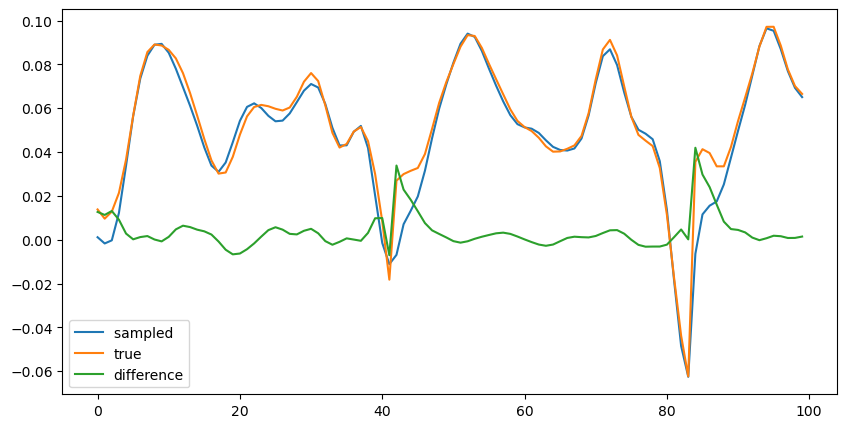

In [139]:
plt.figure(figsize = (10,5))
plt.plot(ssh_estimated[:100], label = 'sampled ')
plt.plot(SSHA_vector[:100], label= 'true')
plt.plot(SSHA_vector[:100] - ssh_estimated[:100], label= 'difference')
# plt.plot(cor_err, label= 'true')
# plt.plot(msla_estimated_swath, label = 'estimate')
plt.legend()

#### build satellite swath

In [22]:
swath_width, x_swath = 6, 20
days = np.arange(day0, day1)

In [23]:
xvalid_index, yvalid_index, tindex, yswath_index_left, yswath_index_right, y_mask_left, y_mask_right = build_swath(swath_width, x_swath, days, lon, lat)

#### Add errors to the swaths

In [24]:
time_factor = np.arange(1, 1 + day1-day0)

In [25]:
# generate error parameter with Gaussian distribution 
alpha = np.zeros([Tdim, 7, 2]) #np.random.normal(mu, sigma, Tdim * 7).reshape(Tdim, 7) #
for nn in range(7):
    for lr in range(2):
        alpha[:, nn, lr] = np.random.normal(mu, sigma, Tdim) #TEST

In [26]:
timing_err_valid, roll_err_valid, baseline_dilation_err_valid, phase_err_valid, xc1_valid, xc2_valid  = make_error_over_time(days, alpha, yswath_index_left, yswath_index_right, y_mask_left, y_mask_right)

In [27]:
# Compute the RMS for each variable
rms_timing_err = np.sqrt(np.mean(timing_err_valid**2))
rms_roll_err = np.sqrt(np.mean(roll_err_valid**2))
rms_baseline_dilation_err = np.sqrt(np.mean(baseline_dilation_err_valid**2))
rms_phase_err = np.sqrt(np.mean(phase_err_valid**2))
rms_timing_err, rms_roll_err, rms_baseline_dilation_err, rms_phase_err

(0.0034060654545949357,
 0.006181259416078179,
 0.01379365891427067,
 0.006452945565419424)

#### sample SSH, errors and add white noise 

In [28]:
IND_TIMINGl = -7 -7
IND_ROLLl = -6 -7
IND_BASELINEl = -5 -7
IND_PHASE3l, IND_PHASE4l, IND_PHASE5l, IND_PHASE6l = -4 -7, -3-7, -2-7, -1-7

IND_TIMINGr = -7 
IND_ROLLr = -6
IND_BASELINEr = -5
IND_PHASE3r, IND_PHASE4r, IND_PHASE5r, IND_PHASE6r = -4, -3, -2, -1

#### Sub-sample the SSH, correlated errors and H matrix

In [104]:
#### Sub-sample the SSH, correlated errors and H matrix
N = len(tindex) # number of data
MSLA_swath = np.zeros(N)
M = l_n.size * k_n.size
nx, ny = len(lon), len(lat)
H_swath = np.zeros([N, 2 * M + Tdim * 7*2]) # M: number of model
IIndex = np.zeros(N) # N: Number of y data
cor_err = np.zeros(N) # Correlated Error N: Number of y data
Y_v = np.zeros(N)
ssh = np.zeros(N)
counter = 0
mask=np.zeros([MSLA_fwd.shape[0],MSLA_fwd.shape[1],MSLA_fwd.shape[2]])

for ii in range(N):
    IIndex[ii] = nx * ny * tindex[ii] + xvalid_index[ii] + nx*yvalid_index[ii] # index in the vector space
    ssh[ii] = MSLA_fwd[xvalid_index[ii], yvalid_index[ii], int(tindex[ii])]
    cor_err[ii] = timing_err_valid.flatten()[ii] + roll_err_valid.flatten()[ii] + baseline_dilation_err_valid.flatten()[ii] + phase_err_valid.flatten()[ii]
    MSLA_swath[ii] = ssh[ii] #+ cor_err[ii] # filtered AVISO SSH , no error along the satellite passings
    mask[xvalid_index[ii], yvalid_index[ii], int(tindex[ii])] = 1
    
    for nn in range(M):
        JIndex = 2 * MModes * nn # +  2 * mm # Model space
        H_swath[ii, JIndex] = H_cos[IIndex[ii].astype(int), nn]
        H_swath[ii, JIndex + 1] = H_sin[IIndex[ii].astype(int), nn]

In [140]:
#### Sub-sample the SSH, correlated errors and H matrix
N = len(tindex) # number of data
MSLA_swath = np.zeros(N)
M = l_n.size * k_n.size
nx, ny = len(lon), len(lat)
H_swath = np.zeros([N, 2 * M + Tdim * 7*2]) # M: number of model
IIndex = np.zeros(N) # N: Number of y data
cor_err = np.zeros(N) # Correlated Error N: Number of y data
Y_v = np.zeros(N)
ssh = np.zeros(N)
counter = 0
mask=np.zeros([MSLA_fwd.shape[0],MSLA_fwd.shape[1],MSLA_fwd.shape[2]])

for ii in range(N):
    IIndex[ii] = nx * ny * tindex[ii] + xvalid_index[ii] + nx*yvalid_index[ii] # index in the vector space
    ssh[ii] = MSLA_fwd[yvalid_index[ii], xvalid_index[ii], int(tindex[ii])]
    cor_err[ii] = timing_err_valid.flatten()[ii] + roll_err_valid.flatten()[ii] + baseline_dilation_err_valid.flatten()[ii] + phase_err_valid.flatten()[ii]
    MSLA_swath[ii] = ssh[ii] #+ cor_err[ii] # filtered AVISO SSH , no error along the satellite passings
    mask[yvalid_index[ii], xvalid_index[ii], int(tindex[ii])] = 1
    
    for nn in range(M):
        JIndex = 2 * MModes * nn # +  2 * mm # Model space
        H_swath[ii, JIndex] = H_cos[IIndex[ii].astype(int), nn]
        H_swath[ii, JIndex + 1] = H_sin[IIndex[ii].astype(int), nn]

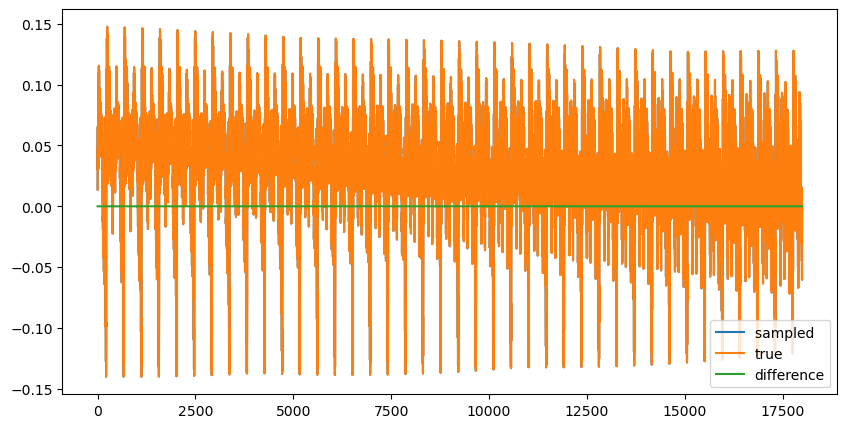

In [141]:
plt.figure(figsize = (10,5))
plt.plot(MSLA_swath, label = 'sampled ')
plt.plot(ssh, label= 'true')
plt.plot(ssh- MSLA_swath, label= 'difference')
# plt.plot(cor_err, label= 'true')
# plt.plot(msla_estimated_swath, label = 'estimate')
plt.legend()

# Important parameter: Root mean squared correlated error and ssh

In [142]:
rms_err = np.sqrt(np.mean(cor_err**2))
rms_ssh = np.sqrt(np.mean(ssh**2))

In [143]:
left_valid = len(yswath_index_left.compressed().astype(int))
right_valid = len(yswath_index_right.compressed().astype(int))
Valid_points = len(xvalid_index) // Tdim
err_basis_func = np.zeros([len(xvalid_index), 7*2])
for tt in range(Tdim):
    for ii in range(left_valid):
        #timing error
        err_basis_func[ii+tt*Valid_points, IND_TIMINGl] = 1 #  alpha_timing, TIMING ERR, distance from nadir Xc
        # roll error = alpha[1] * Xc^1
        err_basis_func[ii+tt*Valid_points, IND_ROLLl] = xc1_valid[tt, ii]  # alpha_roll, ROLL ERR, distance from nadir Xc
        # baseline dialation error = alpha[2] * Xc^2
        err_basis_func[ii+tt*Valid_points, IND_BASELINEl] = xc2_valid[tt, ii]  # alpha_base, BASELINE DIALATION ERR, distance from nadir Xc 
        # phase error 
        H_neg = np.heaviside(-1 * xc1_valid[tt, ii], 1) #
        H_pos = np.heaviside(xc1_valid[tt, ii], 1) # 
        err_basis_func[ii+tt*Valid_points, IND_PHASE3l] = H_neg                 # alpha_phase3 * np.heaviside(xx - xc, 1)
        err_basis_func[ii+tt*Valid_points, IND_PHASE4l] = xc1_valid[tt, ii] * H_neg # alpha_phase4 * Xc * np.heaviside(xx - xc, 1)
        err_basis_func[ii+tt*Valid_points, IND_PHASE5l] = H_pos                 # alpha_phase5 * np.heaviside(xx + xc, 1)
        err_basis_func[ii+tt*Valid_points, IND_PHASE6l] = xc1_valid[tt, ii] * H_pos # alpha_phase6 * np.heaviside(xx + xc, 1)
        
for tt in range(Tdim):
    for ii in range(left_valid, Valid_points):
        #timing error
        err_basis_func[ii+tt*Valid_points, IND_TIMINGr] = 1 #  alpha_timing, TIMING ERR, distance from nadir Xc
        # roll error = alpha[1] * Xc^1
        err_basis_func[ii+tt*Valid_points, IND_ROLLr] = xc1_valid[tt, ii]  # alpha_roll, ROLL ERR, distance from nadir Xc
        # baseline dialation error = alpha[2] * Xc^2
        err_basis_func[ii+tt*Valid_points, IND_BASELINEr] = xc2_valid[tt, ii]  # alpha_base, BASELINE DIALATION ERR, distance from nadir Xc 
        # phase error 
        H_neg = np.heaviside(-1 * xc1_valid[tt, ii], 1) #
        H_pos = np.heaviside(xc1_valid[tt, ii], 1) # 
        err_basis_func[ii+tt*Valid_points, IND_PHASE3r] = H_neg                 # alpha_phase3 * np.heaviside(xx - xc, 1)
        err_basis_func[ii+tt*Valid_points, IND_PHASE4r] = xc1_valid[tt, ii] * H_neg # alpha_phase4 * Xc * np.heaviside(xx - xc, 1)
        err_basis_func[ii+tt*Valid_points, IND_PHASE5r] = H_pos                 # alpha_phase5 * np.heaviside(xx + xc, 1)
        err_basis_func[ii+tt*Valid_points, IND_PHASE6r] = xc1_valid[tt, ii] * H_pos # alpha_phase6 * np.heaviside(xx + xc, 1)

In [144]:
err_basis_func.shape, H_swath.shape

((18000, 14), (18000, 940))

In [145]:
for tt in range(Tdim):
    # print(2 * M + tt * 7 , 2 * M + (tt+1) * 7)
    H_swath[:, 2 * M + tt * 14 : 2 * M + (tt+1) * 14] = err_basis_func

In [146]:
14 * Tdim + 380 # 14 errors + 380 waves

940

In [147]:
Valid_points * Tdim # valid points sampled over time

18000

#### signal to noise ratio

In [148]:
counter = 0
exp = -2
ssh_std = .1
k0 = l_n.max() # flat at or below k0 
p_diagonal = np.zeros([2 * M + Tdim * 7*2])
kl, kl_plot = np.zeros(M), np.zeros(2*M)
k_, l_ = np.zeros(len(l_n)*len(k_n)), np.zeros(len(l_n)*len(k_n))
counter = 0
R = 0.01 # noise = 10. cm

for kk in k_n:
    for ll in l_n:
        k_[counter] , l_[counter]  = kk, ll
        kl[counter] =  np.sqrt(kk ** 2 + ll ** 2) # wavenumber
        kl_plot[2 * counter], kl_plot[2 * counter + 1] = kl[counter], kl[counter]
        p_diagonal[2 * counter] = (kl[counter]+k0) ** exp  * p_factor
        p_diagonal[2 * counter + 1] = (kl[counter]+k0) ** exp  * p_factor
        counter += 1   

p_diagonal[2*M:] = sigma ** 2 # errors

P_matrix = np.zeros([2 * M + Tdim * 7*2, 2 * M +  Tdim * 7*2])

np.fill_diagonal(P_matrix[:],  R / p_diagonal)

/var/folders/tb/ynf00vf51q52gx0ngbt970v00000gn/T/ipykernel_27670/2040414818.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k_[counter] , l_[counter]  = kk, ll
/var/folders/tb/ynf00vf51q52gx0ngbt970v00000gn/T/ipykernel_27670/2040414818.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kl[counter] =  np.sqrt(kk ** 2 + ll ** 2) # wavenumber


In [149]:
Y_vector = Y_v #.flatten()# Reshape Y_v to a 1D array
H_matrix = H_swath #.reshapezz((Tdim * Valid_points, 2 * M + Tdim * 7))

#### diagnostics: fit error to error basis functions

#### Solve for amplitudes

In [150]:
amp_swath, msla_estimated_swath = inversion(MSLA_swath, H_swath, P_matrix) # assimilate the filtered AVISO SSH + error

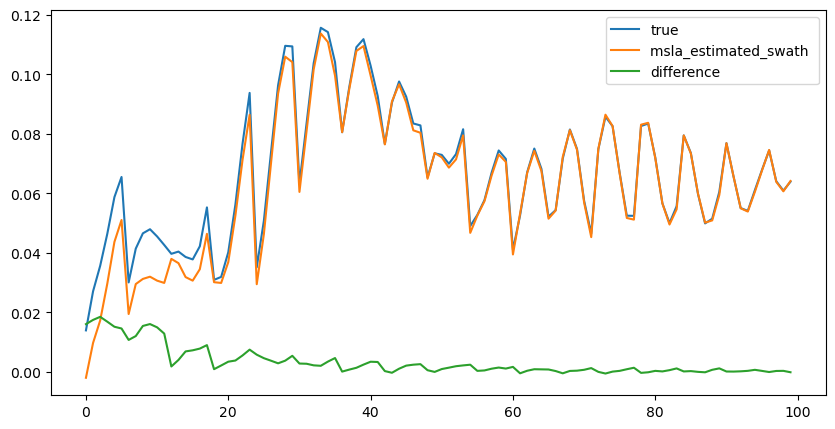

In [151]:
plt.figure(figsize = (10,5))
plt.plot(ssh[:100], label= 'true')
plt.plot(msla_estimated_swath[:100], label = 'msla_estimated_swath ')

plt.plot(ssh[:100] - msla_estimated_swath[:100], label= 'difference')
# plt.plot(cor_err, label= 'true')
# plt.plot(msla_estimated_swath, label = 'estimate')
plt.legend()

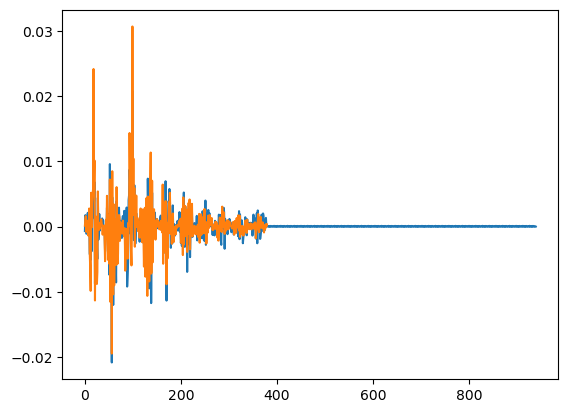

In [152]:
plt.plot(amp_swath) 
plt.plot(amp_all_data)

In [153]:
MSLA.shape

(40, 42, 1)

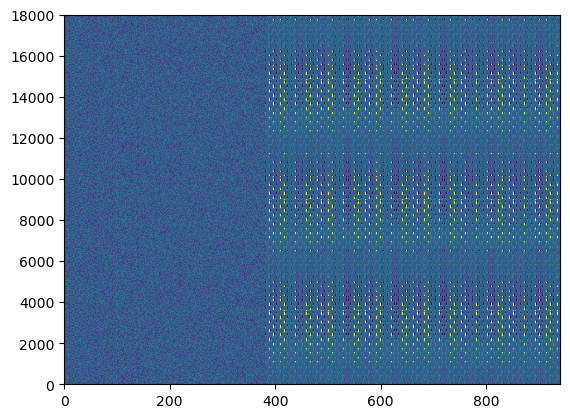

In [154]:
plt.pcolormesh(H_matrix)

#### estimate the errors and ssh : H * amp

In [155]:
err_est_1step = np.matmul(H_matrix[:, -14*Tdim:], amp_swath[-14*Tdim:])
ssh_est_1step = np.matmul(H_matrix[:, :-14*Tdim], amp_swath[:-14*Tdim])

# Important result: error estimate skill and ssh estimate skill of the entire time series

In [156]:
ssh_diff = ssh_est_1step - ssh
err_diff = err_est_1step - cor_err
ssh_diff1 = (np.mean(ssh_diff**2)) / (np.mean(ssh**2))
err_diff1  = (np.mean(err_diff**2).mean()) / (np.mean(cor_err**2))

#### Reverse the vectorization on the swaths

#### Make predictions of SSH based on the estimated amplitudes:
#### Swath data, with errors

#### One approach sanity check: fit errors to seven error basis functions

In [157]:
HTH = np.matmul(H_matrix[:, -7*2 * Tdim:].T, H_matrix[:, -7*2 * Tdim:])

In [158]:
amp_err_only,  err_estimated_swath1 = inversion(cor_err, H_matrix[:, -7*2*Tdim:], P_matrix[-7*2*Tdim:, -7*2*Tdim:])
err_est_err_only = np.matmul(H_matrix[:, -7*2*Tdim:], amp_err_only[-7*2*Tdim:])

In [159]:
amp_diff_1step = amp_swath[-7*2 * Tdim:] - alpha.flatten()
amp_diff_err_only = amp_err_only[-7*2 * Tdim:] - alpha.flatten()

In [160]:
import seaborn as sns

In [161]:
err_1step = amp_swath[-7*2 * Tdim:].reshape(Tdim, 14)
err_diff_1step = amp_diff_1step.reshape(Tdim, 14)

In [162]:
# SSHA_predicted = np.zeros([time_range, MSLA0[:, :, 0:1].size])
# SSHA_true = np.zeros([time_range, MSLA0[:, :, 0:1].size])
# variance_explained_inverse  = np.zeros(time_range)
# MSLA_fwrd_1step = np.zeros([MSLA0.shape[0], MSLA0.shape[1], time_range])

# for day in range(0, time_range):
#     # SSH data
#     MSLA = MSLA_fwd[:, :, day0+day: day0+day+1]
#     # Build basis function H matrix
#     H_all = build_h_matrix(MSLA, MModes, k_n, l_n, lon, lat, T_time[day0:], Psi, Rm, day0 - day0 + day)
#     # forecast SSH
#     SSHA_predicted[day], SSHA_true[day], variance_explained_inverse[day] = forecast_ssh(MSLA, amp_swath[:380],  H_all)
#     # reverse vector
#     MSLA_fwrd_1step[:, :, day:day+1] = reverse_vector(MSLA, SSHA_predicted[day])

### Two-stage approach: reconstructing the SSH separately from solving the correlated error

#### First step: fit errors

#### Sub-sample the SSH, correlated errors and H matrix

In [163]:
H_v1 = H_swath[:, -7*2 * Tdim:]

In [164]:
P_over_R1 = P_matrix[-7*2* Tdim:, -7*2* Tdim:]#.mean(axis = 0)

In [165]:
HTH = np.matmul(H_v1.T, H_v1)

In [166]:
HRH = HTH + P_over_R1 # P: uncertainty in model, R: uncertainty in data
D = np.matmul(LA.inv(HRH), H_v1.T)   

In [167]:
amp_err = np.matmul(D, MSLA_swath)

#### correlated error estimate

In [168]:
err_est_2step = np.matmul(H_v1, amp_err)

#### SSH + correlated errors - estimated correlated errors

In [169]:
tau_ssh = MSLA_swath - err_est_2step

#### second step: fit residual to rossby wave models

In [170]:
H_v = H_swath[:, :-7*2 * Tdim]
HTH = np.matmul(H_v.T, H_v)
HRH = np.zeros(HTH.shape)
HRH = HTH +  P_matrix[:-7*2 * Tdim, :-7*2 * Tdim]
D = np.matmul(LA.inv(HRH), H_v.T)
eig, vec = LA.eig(HRH)

#### Soution with noise, 2 step approach

In [171]:
amp_swath_2step = np.matmul(D, tau_ssh)

#### Prediction with new amplitudes in the next 40 days

In [172]:
ssh_est_2step = np.matmul(H_v, amp_swath_2step)

# Important result: 2-stage error estimate skill and ssh estimate skill

In [173]:
ssh_diff = ssh_est_2step - ssh
err_diff = err_est_2step - cor_err
ssh_diff_2stage = (np.mean(ssh_diff**2)) / (np.mean(ssh**2))
err_diff_2stage  = (np.mean(err_diff**2)) / (np.mean(cor_err**2))

In [174]:
(1 - ssh_diff_2stage.mean()) * 100, (1 - err_diff_2stage.mean()) * 100

(58.86116306523533, -389.7381016141725)

# Important parameter: Root mean squared correlated error and ssh

In [175]:
rms_err = np.sqrt(np.mean(cor_err**2))
rms_ssh = np.sqrt(np.mean(ssh**2))
sigma, rms_err, rms_err/ rms_ssh * 100

(0.0035, 0.016890164820100084, 30.898703228677153)

# Important result: 2-stage error estimate skill and ssh estimate skill

In [176]:
(1-ssh_diff_2stage.mean()) * 100, (1 - err_diff_2stage.mean()) * 100

(58.86116306523533, -389.7381016141725)

# Important result: 1-stage error estimate skill and ssh estimate skill

In [177]:
err_map2 = np.zeros([ny, nx, time_range])
ssh_true2 = np.zeros([ny, nx, time_range])
ssh_2step = np.zeros([ny, nx, time_range])
err_true2 = np.zeros([ny, nx, time_range])
for ii, idx in enumerate(xvalid_index):
    tt = tindex[ii].astype(int)
    err_map2[yvalid_index[ii], xvalid_index[ii], tt] = err_est_2step[ii] 
    ssh_true2[yvalid_index[ii], xvalid_index[ii], tt] = ssh[ii]
    err_true2[yvalid_index[ii], xvalid_index[ii], tt] = cor_err[ii]
    ssh_2step[yvalid_index[ii], xvalid_index[ii], tt] = ssh_est_2step[ii]

In [178]:
ssh_diff2=np.zeros([time_range])
err_diff2=np.zeros([time_range])
nslice=450
for tt in range(time_range):
    ssh_diff = ssh_est_2step[tt*nslice:(tt+1)*nslice] - ssh[tt*nslice:(tt+1)*nslice]
    err_diff = err_est_2step[tt*nslice:(tt+1)*nslice] - cor_err[tt*nslice:(tt+1)*nslice]
    ssh_diff2[tt] = (np.mean(ssh_diff**2)) / (np.mean(ssh**2))
    err_diff2[tt]  = (np.mean(err_diff**2)) / (np.mean(cor_err**2))

/Users/yugao/opt/miniconda3/envs/pyenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/yugao/opt/miniconda3/envs/pyenv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [179]:
ssh_diff_2step = (np.mean((ssh_true2 - ssh_2step) ** 2 ))/ (np.mean((ssh_true2) ** 2 ))
err_diff_2step = (np.mean((err_true2 - err_map2) ** 2 ))/ (np.mean((err_true2) ** 2 ))

#### Make predictions of SSH based on the estimated amplitudes:
#### Swath data, with errors

#### True and estimated SSH and Errors

In [180]:
err_map1 = np.zeros([len(lat), len(lon), time_range])
ssh_map1 = np.zeros([len(lat), len(lon), time_range])
ssh_true1 = np.zeros([len(lat), len(lon), time_range])
err_true1 = np.zeros([len(lat), len(lon), time_range])
lon_valid = np.ma.masked_all([len(lat), len(lon), time_range])
lat_valid = np.ma.masked_all([len(lat), len(lon), time_range])
for ii, idx in enumerate(xvalid_index):
    tt=tindex[ii].astype(int)
    err_map1[yvalid_index[ii], xvalid_index[ii], tt] = err_est_1step[ii] 
    ssh_map1[yvalid_index[ii], xvalid_index[ii], tt]  = ssh_est_1step[ii]
    err_true1[yvalid_index[ii], xvalid_index[ii], tt] = cor_err[ii]
    ssh_true1[yvalid_index[ii], xvalid_index[ii], tt] = ssh[ii]
    lon_valid[yvalid_index[ii], xvalid_index[ii], tt] = lon[xvalid_index[ii]]
    lat_valid[yvalid_index[ii], xvalid_index[ii], tt] = lat[yvalid_index[ii]]

#### Reverse the vectorization on the swaths

In [181]:
ssh_diff1=np.zeros([time_range])
err_diff1=np.zeros([time_range])
nslice=450
for tt in range(time_range):
    ssh_diff = ssh_est_1step[tt*nslice:(tt+1)*nslice] - ssh[tt*nslice:(tt+1)*nslice]
    err_diff = err_est_1step[tt*nslice:(tt+1)*nslice] - cor_err[tt*nslice:(tt+1)*nslice]
    ssh_diff1[tt] = (np.mean(ssh_diff**2)) / (np.mean(ssh**2))
    err_diff1[tt]  = (np.mean(err_diff**2)) / (np.mean(cor_err**2))

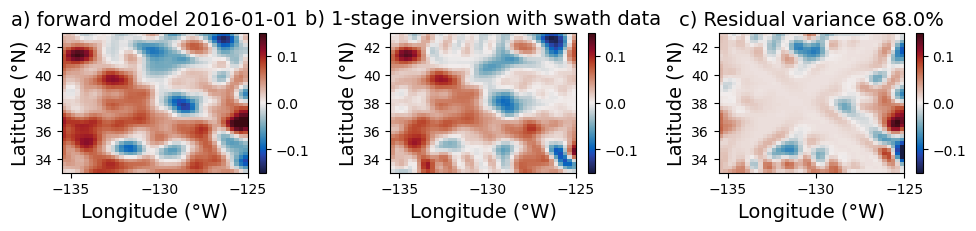

In [191]:
SSHA_predicted = np.zeros([time_range, MSLA0[:, :, 0:1].size])
SSHA_predicted1 = np.zeros([time_range, MSLA0[:, :, 0:1].size])
SSHA_true1 = np.zeros([time_range, MSLA0[:, :, 0:1].size])
SSHA_true = np.zeros([time_range, MSLA0[:, :, 0:1].size])
variance_explained_inverse2  = np.zeros(time_range)
variance_explained_inverse1  = np.zeros(time_range)
MSLA_fwrd_2step = np.zeros([MSLA0.shape[0], MSLA0.shape[1], time_range])
MSLA_fwrd_1step = np.zeros([MSLA0.shape[0], MSLA0.shape[1], time_range])

for day in range(time_range):
    # SSH data
    MSLA = MSLA_fwd[:, :, day0+day: day0+day+1]
    # Build basis function H matrix
    # H_all = build_h_matrix(MSLA, MModes, k_n, l_n, lon, lat, T_time[day0:], Psi, Rm, day0 - day0 + day)
    H_all = build_h_matrix(MSLA, MModes, k_n, l_n, lon, lat, T_time, Psi, Rm, day)
    # forecast SSH
    SSHA_predicted[day], SSHA_true[day], variance_explained_inverse2[day] = forecast_ssh(MSLA, amp_swath_2step,  H_all)
    SSHA_predicted1[day], SSHA_true[day], variance_explained_inverse1[day] = forecast_ssh(MSLA, amp_swath[:380],  H_all)
    # reverse vector
    MSLA_fwrd_2step[:, :, day:day+1] = reverse_vector(MSLA, SSHA_predicted[day])
    MSLA_fwrd_1step[:, :, day:day+1] = reverse_vector(MSLA, SSHA_predicted1[day])
    
    if day == 0:
        count = 0
        plt.figure(figsize = (10, 6))
        plt.subplot(3, 3, count + 1)
        plt.pcolormesh(lon, lat, MSLA[:, :, 0], cmap = cmo.cm.balance, vmin = -.15, vmax = .15) 
        plt.colorbar()
        plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
        plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
        plt.title( 'a) forward model ' + str(date_time[day])[:10], fontsize = 14)

        plt.subplot(3, 3, count + 2)
        plt.pcolormesh(lon, lat, MSLA_fwrd_1step[:, :, day], vmin = -.15, vmax = .15, cmap = cmo.cm.balance)
        plt.colorbar()
        plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
        plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
        plt.title('b) 1-stage inversion with swath data', fontsize = 14)

        residual = MSLA[:, :, 0] - MSLA_fwrd_1step[:, :, day] 
        plt.subplot(3, 3, count + 3)
        plt.pcolormesh(lon, lat, residual, cmap = cmo.cm.balance, vmin = -.15, vmax = .15)
        plt.colorbar()
        plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
        plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
        plt.title('c) Residual variance ' 
                  + str((variance_explained_inverse2[day]) * 100)[:4] + '%', fontsize = 14)
        count = count + 3
        plt.tight_layout()

# Important parameter: Root mean squared correlated error and ssh

In [186]:
rms_err = np.sqrt(np.mean(cor_err**2))
rms_ssh = np.sqrt(np.mean(ssh**2))

In [187]:
# # compute residual variance in and out of track
# var_in = np.zeros(time_range)
# var_out = np.zeros(time_range)
# var_in2 = np.zeros(time_range)
# var_out2 = np.zeros(time_range)
# for i in range(time_range):
#     msla_in=np.ma.masked_where(mask[:,:,0]==0, MSLA_fwd[:,:,i])
#     msla_out=np.ma.masked_where(mask[:,:,0]==1, MSLA_fwd[:,:,i])
#     var_in[i]=np.mean(np.mean((MSLA_fwrd_1step[:,:,i])**2,axis=1),axis=0) / (np.mean(np.mean(msla_in**2,axis=1),axis=0))
#     var_out[i]=np.mean(np.mean((MSLA_fwrd_1step[:,:,i])**2,axis=1),axis=0) / (np.mean(np.mean(msla_out**2,axis=1),axis=0))
#     var_in2[i]=np.mean(np.mean((MSLA_fwrd_2step[:,:,i])**2,axis=1),axis=0) / (np.mean(np.mean(msla_in**2,axis=1),axis=0))
#     var_out2[i]=np.mean(np.mean((MSLA_fwrd_2step[:,:,i])**2,axis=1),axis=0) / (np.mean(np.mean(msla_out**2,axis=1),axis=0))

In [188]:
# Arrays to store variance explained
variance_explained_in_1step = np.zeros(time_range)
variance_explained_out_1step = np.zeros(time_range)
variance_explained_in_2step = np.zeros(time_range)
variance_explained_out_2step = np.zeros(time_range)

for i in range(time_range):
    # Masking the in-track and out-of-track data
    msla_in = np.ma.masked_where(mask[:, :, 0] == 0, MSLA_fwd[:, :, i])
    msla_out = np.ma.masked_where(mask[:, :, 0] == 1, MSLA_fwd[:, :, i])
    
    # Apply the same mask to the predicted data
    msla_fwrd_in_1step = np.ma.masked_where(mask[:, :, 0] == 0, MSLA_fwrd_1step[:, :, i])
    msla_fwrd_out_1step = np.ma.masked_where(mask[:, :, 0] == 1, MSLA_fwrd_1step[:, :, i])
    msla_fwrd_in_2step = np.ma.masked_where(mask[:, :, 0] == 0, MSLA_fwrd_2step[:, :, i])
    msla_fwrd_out_2step = np.ma.masked_where(mask[:, :, 0] == 1, MSLA_fwrd_2step[:, :, i])

    # Variance of original data for in-swath and out-of-swath
    original_var_in = np.var(msla_in)
    original_var_out = np.var(msla_out)

    # Variance of predictions for in-swath and out-of-swath (1-step)
    predicted_var_in_1step = np.var(msla_fwrd_in_1step)
    predicted_var_out_1step = np.var(msla_fwrd_out_1step)

    # Variance of predictions for in-swath and out-of-swath (2-step)
    predicted_var_in_2step = np.var(msla_fwrd_in_2step)
    predicted_var_out_2step = np.var(msla_fwrd_out_2step)

    # Variance explained (1-step)
    variance_explained_in_1step[i] = np.mean((msla_in - msla_fwrd_in_1step)**2) / np.var(msla_in)
    variance_explained_out_1step[i] = np.mean((msla_out - msla_fwrd_out_1step)**2) / np.var(msla_out)

    # Variance explained (2-step)
    variance_explained_in_2step[i] = np.mean((msla_in - msla_fwrd_in_2step)**2) / np.var(msla_in)
    variance_explained_out_2step[i] = np.mean((msla_out - msla_fwrd_out_2step)**2) / np.var(msla_out)

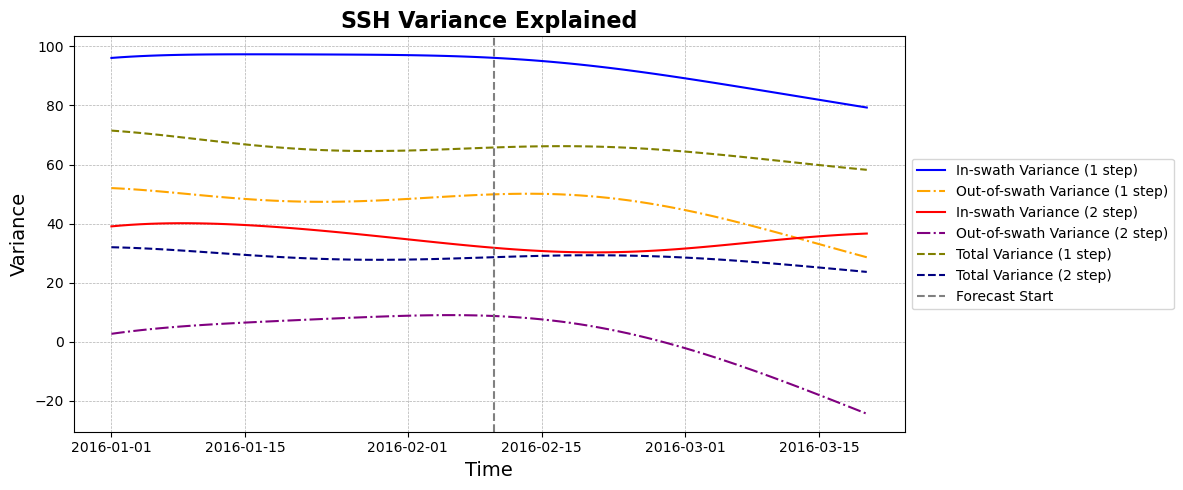

In [192]:
import matplotlib.pyplot as plt

# Set figure size and aspect ratio for landscape orientation
fig, ax = plt.subplots(figsize=(10, 5))

# Define a color sequence for lines for better visibility and differentiation
colors = ['blue', 'orange', 'red', 'purple', 'brown', 'pink', 'gray', 'cyan', 'olive', 'navy']

# Line plots
ax.plot(time[0:time_range], (1- variance_explained_in_1step)*100, label='In-swath Variance (1 step)', linewidth=1.5, color=colors[0], linestyle = '-')
ax.plot(time[0:time_range], (1-variance_explained_out_1step)*100, label='Out-of-swath Variance (1 step)', linewidth=1.5, color=colors[1], linestyle = '-.')
ax.plot(time[0:time_range], (1-variance_explained_in_2step)*100, label='In-swath Variance (2 step)', linewidth=1.5, color=colors[2], linestyle = '-')
ax.plot(time[0:time_range], (1-variance_explained_out_2step)*100, label='Out-of-swath Variance (2 step)', linewidth=1.5, color=colors[3], linestyle = '-.')
ax.plot(time[0:time_range], (1-variance_explained_inverse1[0:])*100, label='Total Variance (1 step)', linewidth=1.5, color=colors[8], linestyle = '--')
ax.plot(time[0:time_range], (1-variance_explained_inverse2[0:])*100, label='Total Variance (2 step)', linewidth=1.5, color=colors[9], linestyle = '--')

# Dashed vertical line at x = 40
ax.axvline(time[day1], color='gray', linestyle='--', label="Forecast Start")

# Adjust plot properties for better clarity
ax.set_title('SSH Variance Explained', fontsize=16, fontweight='bold')
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('Variance', fontsize=14)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust legend position and size
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.75, box.height])
# ax.legend(loc='center left', fontsize = 8)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)

plt.tight_layout()
plt.savefig('explained_variance_'+ str(int((day1 - day0))) +'days_'+ str(date_time[0])[:10] +'.png', dpi=300)
plt.show()

Note that "in swath" and "residual" solutions should match but don't because of double counting of crossover points.

# Important result: 2-stage error estimate skill and ssh estimate skill

In [73]:
# (1 - ssh_diff2.mean()) * 100, (1 - err_diff2.mean()) * 100

In [74]:
# ssh_diff2

# Important result: 1-stage error estimate skill and ssh estimate skill

In [75]:
# (1 - ssh_diff1.mean()) * 100, (1 - err_diff1.mean()) * 100 #, (1 - ssh_diff_percent.mean()) * 100

In [79]:
    
#     if (day % 4 ==0 and day < 12):
#         plt.subplot(3, 3, count + 1)
#         plt.pcolormesh(lon, lat, MSLA[:, :, 0], cmap = cmo.cm.balance, vmin = -.15, vmax = .15) 
#         plt.colorbar()
#         plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
#         plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
#         plt.title(ind_list[count] + ') AVISO forward model ' + str(date_time[day])[:10], fontsize = 14)

#         plt.subplot(3, 3, count + 2)
#         plt.pcolormesh(lon, lat, MSLA_fwrd[:, :, day], vmin = -.15, vmax = .15, cmap = cmo.cm.balance)
#         plt.colorbar()
#         plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
#         plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
#         plt.title(ind_list[count+1] + ') 2-stage inversion with swath data', fontsize = 14)

#         residual = MSLA[:, :, 0] - MSLA_fwrd[:, :, day] 
#         plt.subplot(3, 3, count + 3)
#         plt.pcolormesh(lon, lat, residual, cmap = cmo.cm.balance, vmin = -.15, vmax = .15)
#         plt.colorbar()
#         plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
#         plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
#         plt.title(ind_list[count+2] +') Residual variance ' 
#                   + str((variance_explained_inverse2[day]) * 100)[:4] + '%', fontsize = 14)
#         count = count + 3
#         plt.tight_layout()

# plt.savefig('./ssh_swath' + str(date_time[day0 + day])[:10] +'_2stage.png', dpi = 300)

<Figure size 640x480 with 0 Axes>

In [77]:
# # Compute variance explained in and out of the track
# variance_explained_in = np.zeros(time_range)
# variance_explained_out = np.zeros(time_range)

# for i in range(time_range):
#     # Masking the in-track and out-of-track data
#     msla_in = np.ma.masked_where(mask[:, :, 0] == 0, MSLA_fwd[:, :, i])
#     msla_out = np.ma.masked_where(mask[:, :, 0] == 1, MSLA_fwd[:, :, i])

#     # Calculate the variance of the original and predicted data for in-track
#     original_var_in = np.var(msla_in)
#     predicted_var_in = np.var(MSLA_fwrd_1step[:, :, i])
#     # Variance explained for in-track
#     variance_explained_in[i] = (original_var_in - predicted_var_in) / original_var_in

#     # Calculate the variance of the original and predicted data for out-of-track
#     original_var_out = np.var(msla_out)
#     predicted_var_out = np.var(MSLA_fwrd_1step[:, :, i])
#     # Variance explained for out-of-track
#     variance_explained_out[i] = (original_var_out - predicted_var_out) / original_var_out


In [78]:
# # Compute variance explained in and out of the track for the 2-step approach
# variance_explained_in_2step = np.zeros(time_range)
# variance_explained_out_2step = np.zeros(time_range)

# for i in range(time_range):
#     # Masking the in-track and out-of-track data
#     msla_in_2step = np.ma.masked_where(mask[:, :, 0] == 0, MSLA_fwd[:, :, i])
#     msla_out_2step = np.ma.masked_where(mask[:, :, 0] == 1, MSLA_fwd[:, :, i])

#     # Calculate the variance of the original and predicted data for in-track
#     original_var_in_2step = np.var(msla_in_2step)
#     predicted_var_in_2step = np.var(MSLA_fwrd_2step[:, :, i])
#     # Variance explained for in-track in the 2-step approach
#     variance_explained_in_2step[i] = (original_var_in_2step - predicted_var_in_2step) / original_var_in_2step

#     # Calculate the variance of the original and predicted data for out-of-track
#     original_var_out_2step = np.var(msla_out_2step)
#     predicted_var_out_2step = np.var(MSLA_fwrd_2step[:, :, i])
#     # Variance explained for out-of-track in the 2-step approach
#     variance_explained_out_2step[i] = (original_var_out_2step - predicted_var_out_2step) / original_var_out_2step